In [14]:
import h5py
import numpy as np
from gwpy.timeseries import TimeSeries
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

/work/submit/kyoon/miniforge3/envs/ssm/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [6]:
filename = '/ceph/submit/data/user/k/kyoon/KYoonStudy/BNS/bns_waveforms.hdf5'

In [7]:
with h5py.File(filename, 'r') as f:
    # === Access metadata ===
    coalescence_time = f.attrs['coalescence_time'] # GPS time of coalescence
    duration = f.attrs['duration'] # Duration of the waveform in seconds
    ifos = f.attrs['ifos'] # List of interferometers
    length = f.attrs['length'] # Number of samples.
    num_injections = f.attrs['num_injections'] # Number of waveform injections.
    sample_rate = f.attrs['sample_rate'] # Sample rate in Hz

    print(f'Coalescence time: {coalescence_time}')
    print(f'Duration: {duration} seconds')
    print(f'Interferometers: {", ".join(it for it in ifos)}')
    print(f'Number of samples: {length} samples')
    print(f'Number of injections: {num_injections}')
    print(f'Sample rate: {sample_rate} Hz')

    # === Choose one injection (e.g., the 0th) ===
    waveform_idx = 0
    h1_strain = f['waveforms/h1'][waveform_idx]
    l1_strain = f['waveforms/l1'][waveform_idx]

Coalescence time: 63.0
Duration: 64.0 seconds
Interferometers: H1, L1
Number of samples: 20000 samples
Number of injections: 98323
Sample rate: 2048.0 Hz


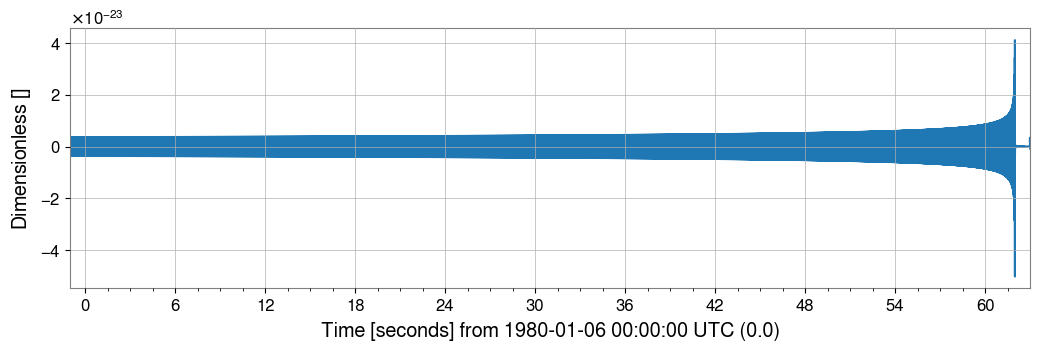

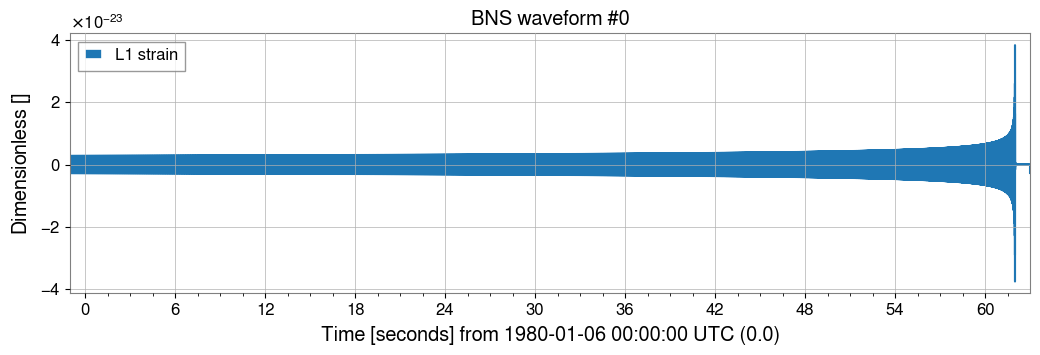

In [10]:
# === Convert to gwpy TimeSeries ===
# Assume coalescence_time is the GPS time of the final sample
start_time = coalescence_time - duration
times = np.linspace(start_time, coalescence_time, int(duration * sample_rate))

h1_ts = TimeSeries(h1_strain, times=times, name='H1')
l1_ts = TimeSeries(l1_strain, times=times, name='L1')

# === Plot example ===
_ = h1_ts.plot(label='H1 strain')
_ = l1_ts.plot(label='L1 strain')
plt.legend()
plt.title(f'BNS waveform #{waveform_idx}')
plt.show()

### Plot the parameters.

Matplotlib is building the font cache; this may take a moment.


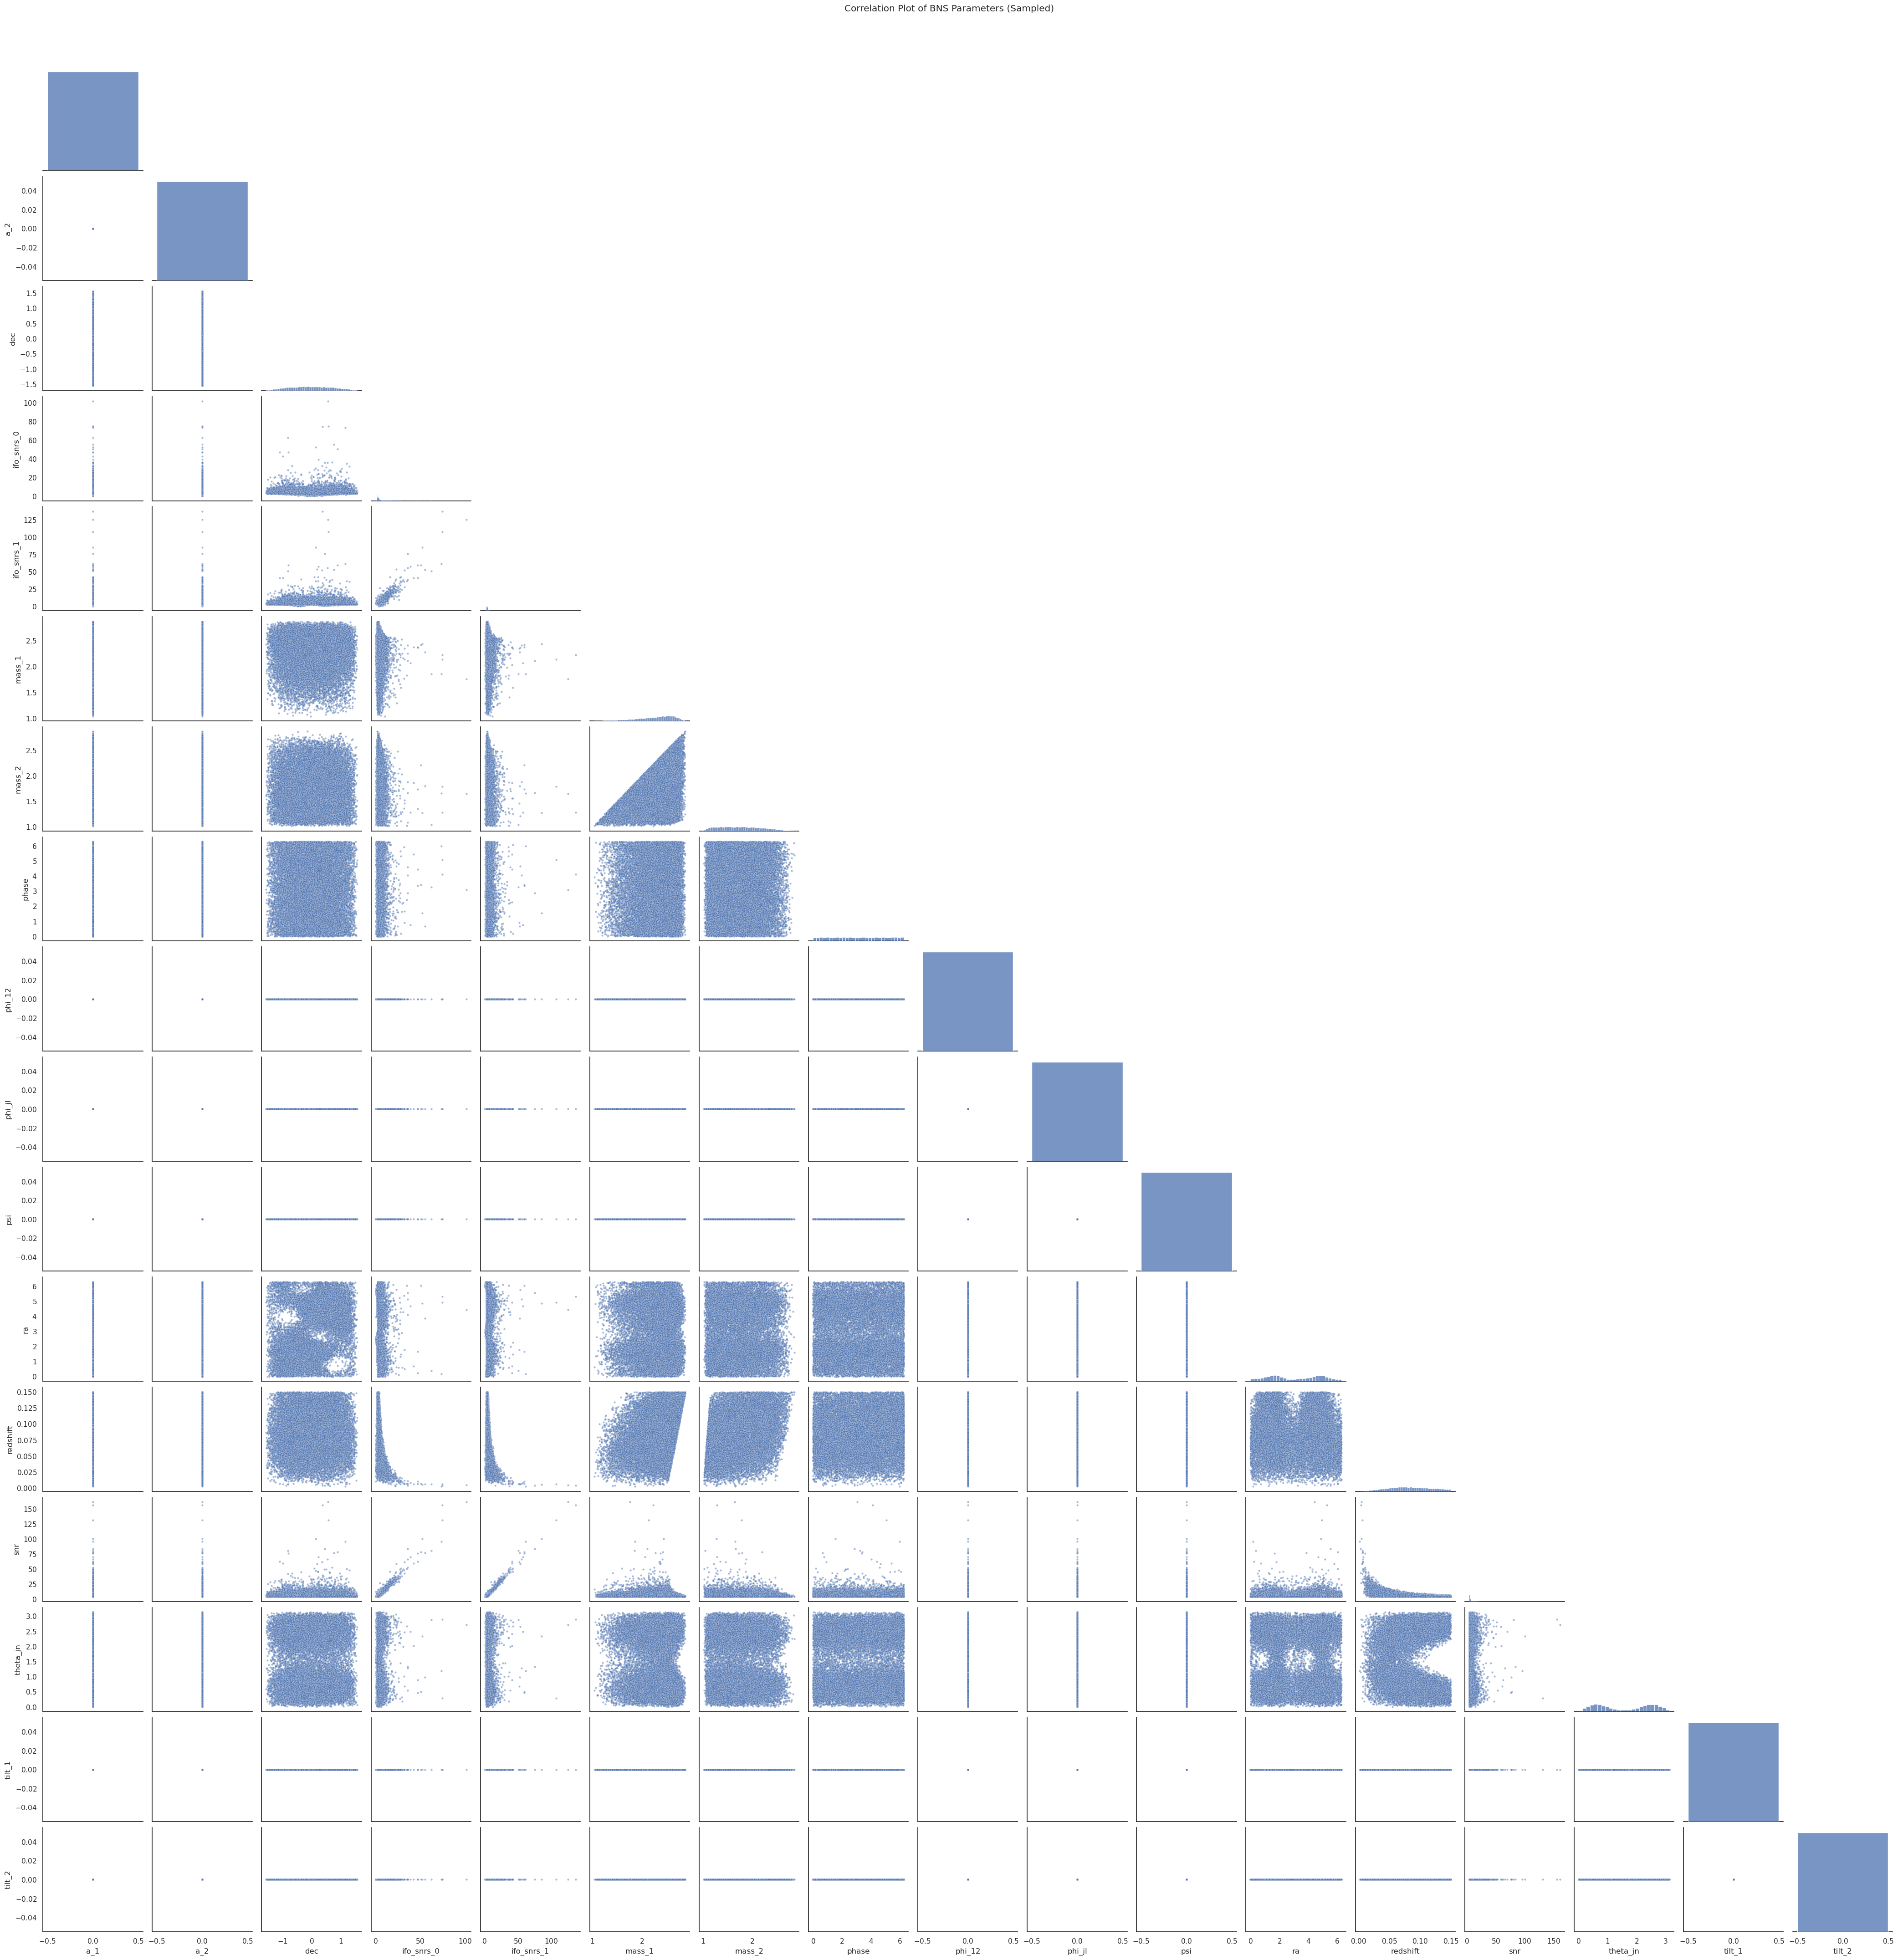

In [17]:
# === Load parameter datasets ===
with h5py.File(filename, "r") as f:
    param_group = f["parameters"]
    parameter_dict = {}
    for key in param_group:
        data = param_group[key][()]
        if data.ndim == 1:
            parameter_dict[key] = data
        elif data.ndim == 2 and data.shape[1] == 2:
            parameter_dict[f"{key}_0"] = data[:, 0]
            parameter_dict[f"{key}_1"] = data[:, 1]

# === Convert to pandas DataFrame ===
df = pd.DataFrame(parameter_dict)

# === Sample (optional) to speed up plotting ===
# df_sampled = df.sample(2000, random_state=42)
df_sampled = df

# === Plot using seaborn pairplot ===
sns.set_theme(style="white", context="notebook")
pairgrid = sns.pairplot(df_sampled, corner=True, plot_kws={"s": 10, "alpha": 0.5})

# === Tweak titles ===
pairgrid.figure.suptitle("Correlation Plot of BNS Parameters (Sampled)", y=1.02)
plt.show()

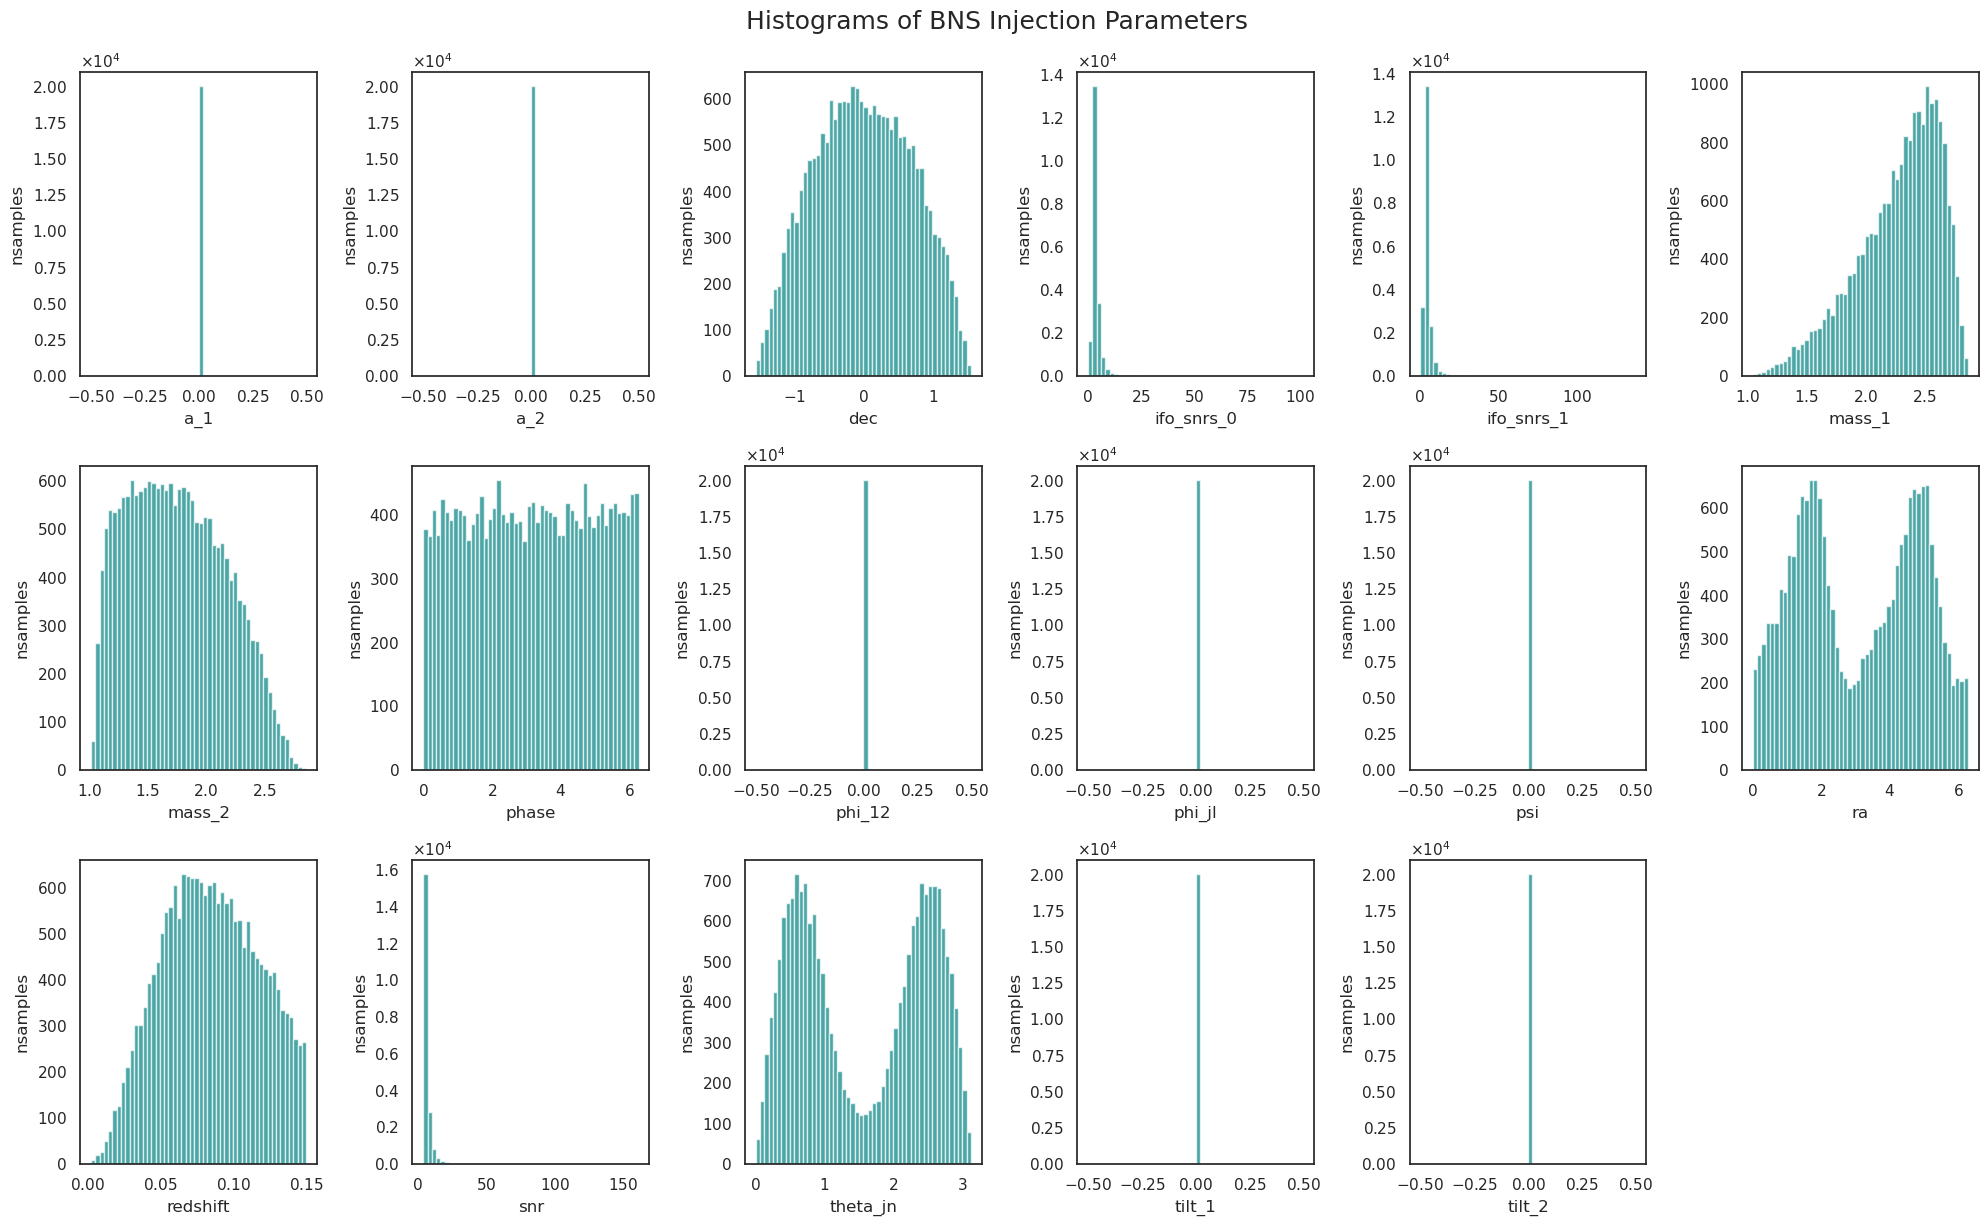

In [23]:
# === Plot histograms ===
num_vars = len(df.columns)
cols = 6
rows = (num_vars + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(20, 4 * rows))
axes = axes.flatten()

for i, col in enumerate(df.columns):
    axes[i].hist(df[col], bins=50, color='teal', alpha=0.7)
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('nsamples')

# Clean up any extra subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.suptitle("Histograms of BNS Injection Parameters", y=1.02, fontsize=18)
plt.show()

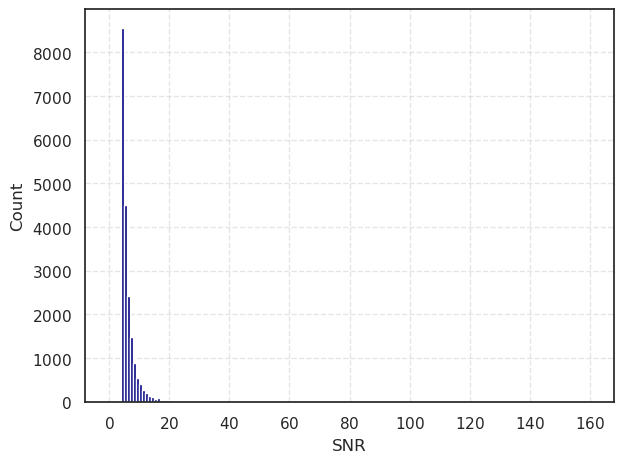

In [39]:
plt.hist(df["snr"], bins=range(0, int(df["snr"].max())), color="navy")
plt.xlabel("SNR")
plt.ylabel("Count")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

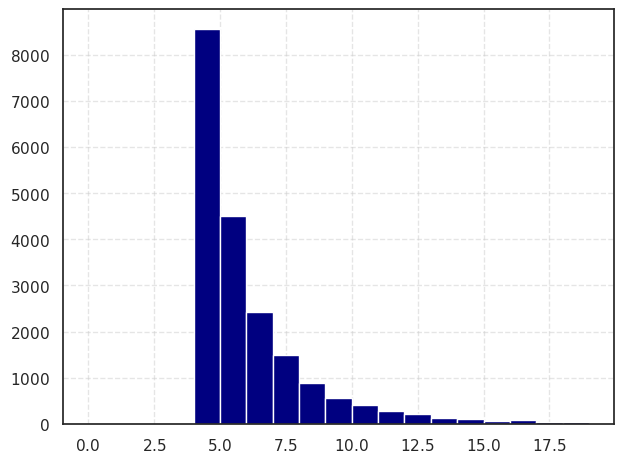

In [40]:
plt.hist(df["snr"], bins=range(0, 20), color="navy")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

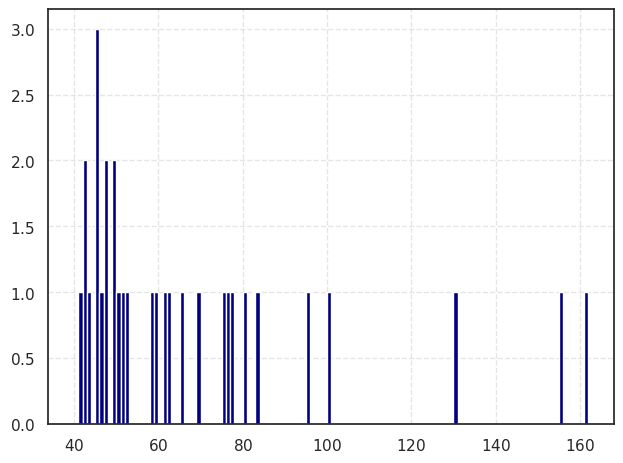

In [38]:
plt.hist(df["snr"], bins=range(40, int(df["snr"].max())+2), color="navy")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

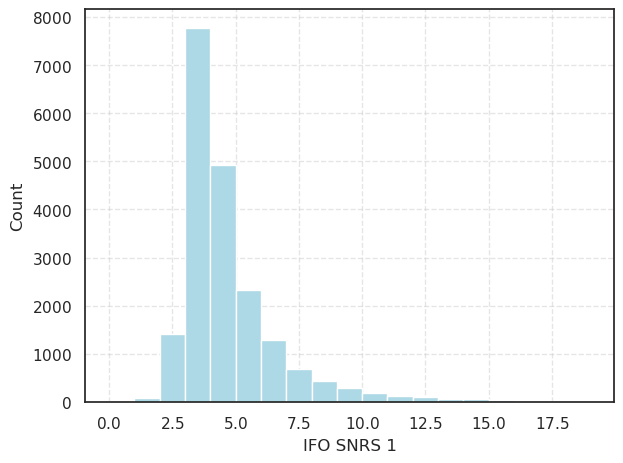

In [50]:
plt.hist(df["ifo_snrs_1"], bins=range(0, 20), color="lightblue")
plt.xlabel("IFO SNRS 1")
plt.ylabel("Count")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

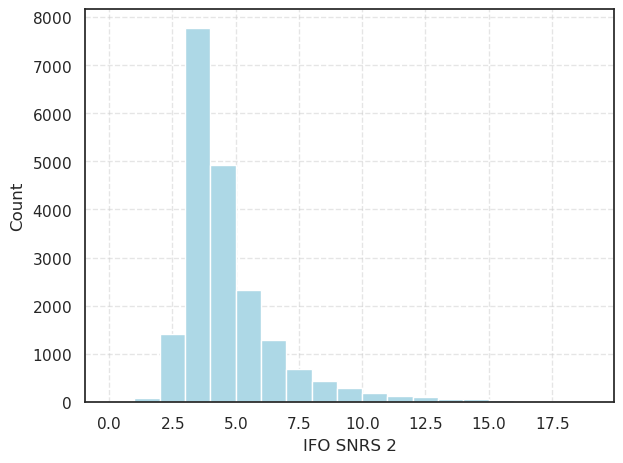

In [49]:
plt.hist(df["ifo_snrs_1"], bins=range(0, 20), color="lightblue")
plt.xlabel("IFO SNRS 2")
plt.ylabel("Count")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

In [53]:
new_df = pd.DataFrame({
    'ifo_snrs_0': df['ifo_snrs_0'],
    'ifo_snrs_1': df['ifo_snrs_1'],
    'ifo_snrs_quad_sum': np.sqrt(df['ifo_snrs_0']**2 + df['ifo_snrs_1']**2),
    'snr': df['snr']
})

In [55]:
print(new_df.sample(20, random_state=42))

       ifo_snrs_0  ifo_snrs_1  ifo_snrs_quad_sum        snr
10650    6.262241    8.388227          10.467952  10.467952
2041     3.405988    2.834754           4.431318   4.431318
8668     3.392563    4.194098           5.394436   5.394436
1114     2.698315    3.400364           4.340896   4.340897
13902   18.825895   23.319220          29.969991  29.969990
11963    2.568943    3.562726           4.392321   4.392321
11072    5.471006    5.638867           7.856763   7.856763
3002     2.829198    3.183093           4.258690   4.258690
19771    2.797290    4.389644           5.205171   5.205172
8115    12.535897   15.351604          19.819699  19.819698
3525     3.967995    5.065403           6.434539   6.434539
7879     2.897821    3.273943           4.372192   4.372192
16441    2.819394    4.197985           5.056882   5.056882
16296    2.896210    4.239064           5.133974   5.133975
12566    2.612709    3.650921           4.489484   4.489484
5252     3.902844    6.531652           